# Generative Adversarial Network (GAN)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [2]:
# Use this for CNN
ds_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.5,),(0.5,)),
                            ]))

## Process

In [3]:
x,t = ds_train.__getitem__(0)

In [4]:
def draw(X):
    img_size = 28
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');
    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

In [5]:
# Batched, for training
batch_size_train = 128
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True)

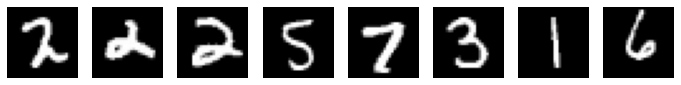

In [6]:
x,t = next(iter(train_dl))
draw(x[:8])

# GAN classes

## CNN GAN
This CNN GAN does not work for some reason. It trains, etc, but does not generate digit-like images.

In [7]:
class gan(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = 100
        self.losses_D = []
        self.losses_G = []
        
        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(),
            nn.Conv2d(64, 128, 3), nn.ReLU(),
            nn.Conv2d(128, 64, 3), nn.ReLU(),
            nn.Flatten(start_dim=1),
        )
        
        # Dhead: Output of the discriminator, Dhead
        blah = torch.zeros((3, 1, 28, 28))
        pen_dim = self.D(blah).shape[-1]
        self.Dhead = nn.Sequential(nn.Linear(pen_dim, 1), nn.Sigmoid())
        
        # Discriminator: D -> Dhead
        self.Discriminator = nn.Sequential(self.D, self.Dhead)
        
        # G: Generator
        self.G = nn.Sequential(
            nn.Linear(self.z_dim, pen_dim),
            Unflatten(-1, (64,22,22)), nn.ReLU(),  # can use Unflatten, defined above
            nn.ConvTranspose2d(64, 128, 3), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3), nn.Tanh(),
        )
        
        self.D_loss_fcn = nn.BCELoss()
        self.G_loss_fcn = nn.BCELoss()
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.Discriminator(x).squeeze()
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.normal(torch.zeros((n,self.z_dim,)), 1.).to(device)
        return self.G(z)
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optim_D = torch.optim.Adam(self.Discriminator.parameters(), lr=lr)
        optim_G = torch.optim.Adam(self.G.parameters(), lr=lr*2.)
        for epoch in tqdm(range(epochs)):
            total_D_loss = 0.
            total_G_loss = 0.
            for x,t in dl:
                x = x.to(device)
                t = t.to(device)
                bs = len(t)
                
                # Generate some inputs
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                x_gen = self.G(z)  # This is the FF pass of the Generator!
                
                # Concat. legit and generated samples together into 1 batch
                x_both = torch.cat((x, x_gen))
                t_both = torch.cat( ( torch.ones((bs,)), torch.zeros((bs,)) ) ).to(device)
                
                # FF pass on the Discriminator
                y = self.discriminate(x_both)
                
                # Discriminator loss (for both true and generated inputs)
                loss_D = self.D_loss_fcn(y, t_both)
                
                # Gradient step for Discriminator
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                # Generator loss
                # (just process the fake images made by the generator)
                # Just like creating an adversarial input, we choose the target
                # we want (t=1), and push the gradient down through the network.
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                y_gen = self.discriminate( self.G(z) ) # FF through both networks z->G->D->y
                loss_G = self.G_loss_fcn(y_gen, torch.ones((len(z),)).to(device) )
                optim_G.zero_grad()
                loss_G.backward()
                optim_G.step()
                
                total_D_loss += loss_D.item()*len(t)
                total_G_loss += loss_G.item()*len(t)
            self.losses_D.append(total_D_loss/len(dl.dataset))
            self.losses_G.append(total_G_loss/len(dl.dataset))
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

## CNN GAN works

In [8]:
# initial weight
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [9]:
class gan(nn.Module):
    def __init__(self):
        super().__init__()
        self.Z_dim = 128
        self.losses_D = []
        self.losses_G = []
        self.Number_Channel = 1
        self.Number_Feature_Dis = 64
        self.Number_Feature_Gen = 64

        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(self.Number_Channel, self.Number_Feature_Dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis) x 14 x 14
            
            nn.Conv2d(self.Number_Feature_Dis, self.Number_Feature_Dis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*2) x 7 x 7
            
            nn.Conv2d(self.Number_Feature_Dis * 2, self.Number_Feature_Dis * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 4 x 4
            
            nn.Conv2d(self.Number_Feature_Dis * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        # G: Generator
        self.G = nn.Sequential(
            
            nn.ConvTranspose2d(self.Z_dim, self.Number_Feature_Gen * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 4),
            nn.ReLU(True),
            # (Number_Feature_Gen*8) x 4 x 4
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 4, self.Number_Feature_Gen * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 2),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 8 x 8
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 2, self.Number_Feature_Gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen),
            nn.ReLU(True),
            # (Number_Feature_Gen*2) x 16 x 16
            
            nn.ConvTranspose2d(self.Number_Feature_Gen, self.Number_Channel, 4, 2, 1, bias=False),
            # 1 * 28 * 28
            
            nn.Tanh()
        )
        self.D.to(device)
        self.G.to(device)
        
        self.Loss_D = nn.BCELoss()
        self.Loss_G = nn.BCELoss()
     #  self.G.apply(weights_init)
      # self.D.apply(weights_init)
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.D(x)
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.randn(n, self.Z_dim, 1, 1, device=device)
        return self.G(z)
    
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optimizerD = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizerG = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        for epoch in tqdm(range(epochs)):
            for x,t in dl:
                real_data = x.to(device)
                batch_size = real_data.size(0)
                label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                
                # (1) Update D network
                self.D.zero_grad()
                output = self.D(real_data).view(-1)
                errD_real = self.Loss_D(output, label) # label it as real image
                errD_real.backward()
                
                # generate fake image
                noise = torch.randn(batch_size, self.Z_dim, 1, 1, device=device)
                fake_data = self.G(noise)
                label.fill_(0.) # fake label
                output = self.D(fake_data.detach()).view(-1) 
                
                # Train D with fake image, fake label
                errD_fake = self.Loss_D(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizerD.step()
                
                # Train G
                self.G.zero_grad()        
                label.fill_(1.)  # label real, same fake imgae
                output = self.D(fake_data).view(-1)
                errG = self.Loss_G(output, label)
                errG.backward()
                optimizerG.step()
                
                self.losses_D.append(errD.item())
                self.losses_G.append(errG.item())
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

# Train it and test it

In [10]:
net = gan()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.17s/it]


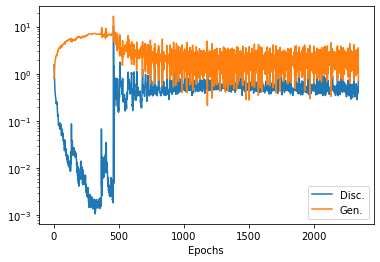

In [11]:
net.learn(train_dl, epochs=5, lr=0.0001)

torch.Size([128, 1, 1, 1])
[[[[0.83168554]]]


 [[[0.9950081 ]]]


 [[[0.916285  ]]]


 [[[0.9816126 ]]]


 [[[0.91360086]]]


 [[[0.91824836]]]


 [[[0.90658593]]]


 [[[0.93320346]]]


 [[[0.9753312 ]]]


 [[[0.9370671 ]]]


 [[[0.9742586 ]]]


 [[[0.9759922 ]]]


 [[[0.9859124 ]]]


 [[[0.91817665]]]


 [[[0.93622595]]]


 [[[0.98752844]]]


 [[[0.98605007]]]


 [[[0.83745223]]]


 [[[0.96101195]]]


 [[[0.96713793]]]


 [[[0.98931736]]]


 [[[0.986081  ]]]


 [[[0.99058574]]]


 [[[0.97348773]]]


 [[[0.9329493 ]]]


 [[[0.96128273]]]


 [[[0.96153367]]]


 [[[0.9382817 ]]]


 [[[0.95834273]]]


 [[[0.9749783 ]]]


 [[[0.9640806 ]]]


 [[[0.9817846 ]]]


 [[[0.9743042 ]]]


 [[[0.9769495 ]]]


 [[[0.9764969 ]]]


 [[[0.9916189 ]]]


 [[[0.94912964]]]


 [[[0.9073513 ]]]


 [[[0.8742973 ]]]


 [[[0.8544292 ]]]


 [[[0.9810898 ]]]


 [[[0.9473596 ]]]


 [[[0.9599024 ]]]


 [[[0.9772463 ]]]


 [[[0.8981199 ]]]


 [[[0.9655417 ]]]


 [[[0.95696175]]]


 [[[0.9762614 ]]]


 [[[0.886443 

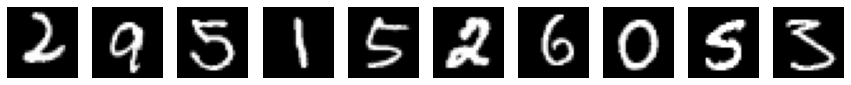

In [12]:
x,t = next(iter(train_dl))
y = net.discriminate(x.to(device))
print(y.shape)
draw(x[:10]);
print(f'{y.detach().cpu().numpy()}')

tensor([[[[0.5488]]],


        [[[0.2776]]],


        [[[0.7594]]],


        [[[0.1579]]],


        [[[0.3646]]],


        [[[0.5610]]],


        [[[0.2830]]],


        [[[0.3885]]],


        [[[0.5480]]],


        [[[0.3343]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


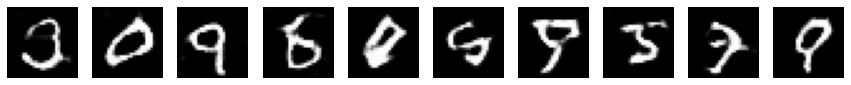

In [13]:
x = net.generate(n=10).to(device)
y = net(x)
draw(x[:10])
print(y)